# Binary Classification of Mushroom

Use a __deep neural network__ for classification of mushrooms in _edible_ and _poisonous_.

___Dataset from___: [mushroom-dataset](https://www.kaggle.com/datasets/prishasawhney/mushroom-dataset)

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow.keras as keras
import numpy as np

2024-06-12 19:02:40.680195: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-12 19:02:40.690781: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-12 19:02:40.818536: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-12 19:02:45.079314: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
#load dataset
df = pd.read_csv('mushroom_cleaned.csv')

## Data Manipulation

Manipualtion of datas to optimize the interpretation from the DNN.

In [4]:
# data normalization and tralation
norm = pd.DataFrame()
for columns in df:
    max_val = np.max(df[columns])
    min_val = np.min(df[columns])
    
    norm[columns] = [min_val , max_val - min_val]
    df[columns]   = (df[columns] - norm[columns][0]) / norm[columns][1]

df

,cap-diameter,cap-shape,gill-attachment,gill-color,stem-height,stem-width,stem-color,season,class
0,0.725542,0.333333,0.333333,0.909091,0.992737,0.432894,0.916667,1.000000,1.0
1,0.772607,0.333333,0.333333,0.909091,0.992737,0.436257,0.916667,1.000000,1.0
2,0.725013,0.333333,0.333333,0.909091,0.941896,0.438778,0.916667,1.000000,1.0
3,0.666843,1.000000,0.333333,0.909091,0.987549,0.438778,0.916667,1.000000,1.0
4,0.690111,1.000000,0.333333,0.909091,0.967835,0.410199,0.916667,0.515404,1.0
...,...,...,...,...,...,...,...,...,...
54030,0.038604,0.833333,0.500000,0.181818,0.231379,0.159428,1.000000,0.515404,1.0
54031,0.043363,0.333333,0.500000,0.181818,0.309197,0.137293,1.000000,0.515404,1.0
54032,0.043363,0.833333,0.500000,0.181818,0.238642,0.163631,1.000000,0.484596,1.0
54033,0.041777,0.333333,0.500000,0.181818,0.269769,0.137574,1.000000,0.484596,1.0


/home/sergio/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/sergio/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/sergio/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/sergio/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Conver

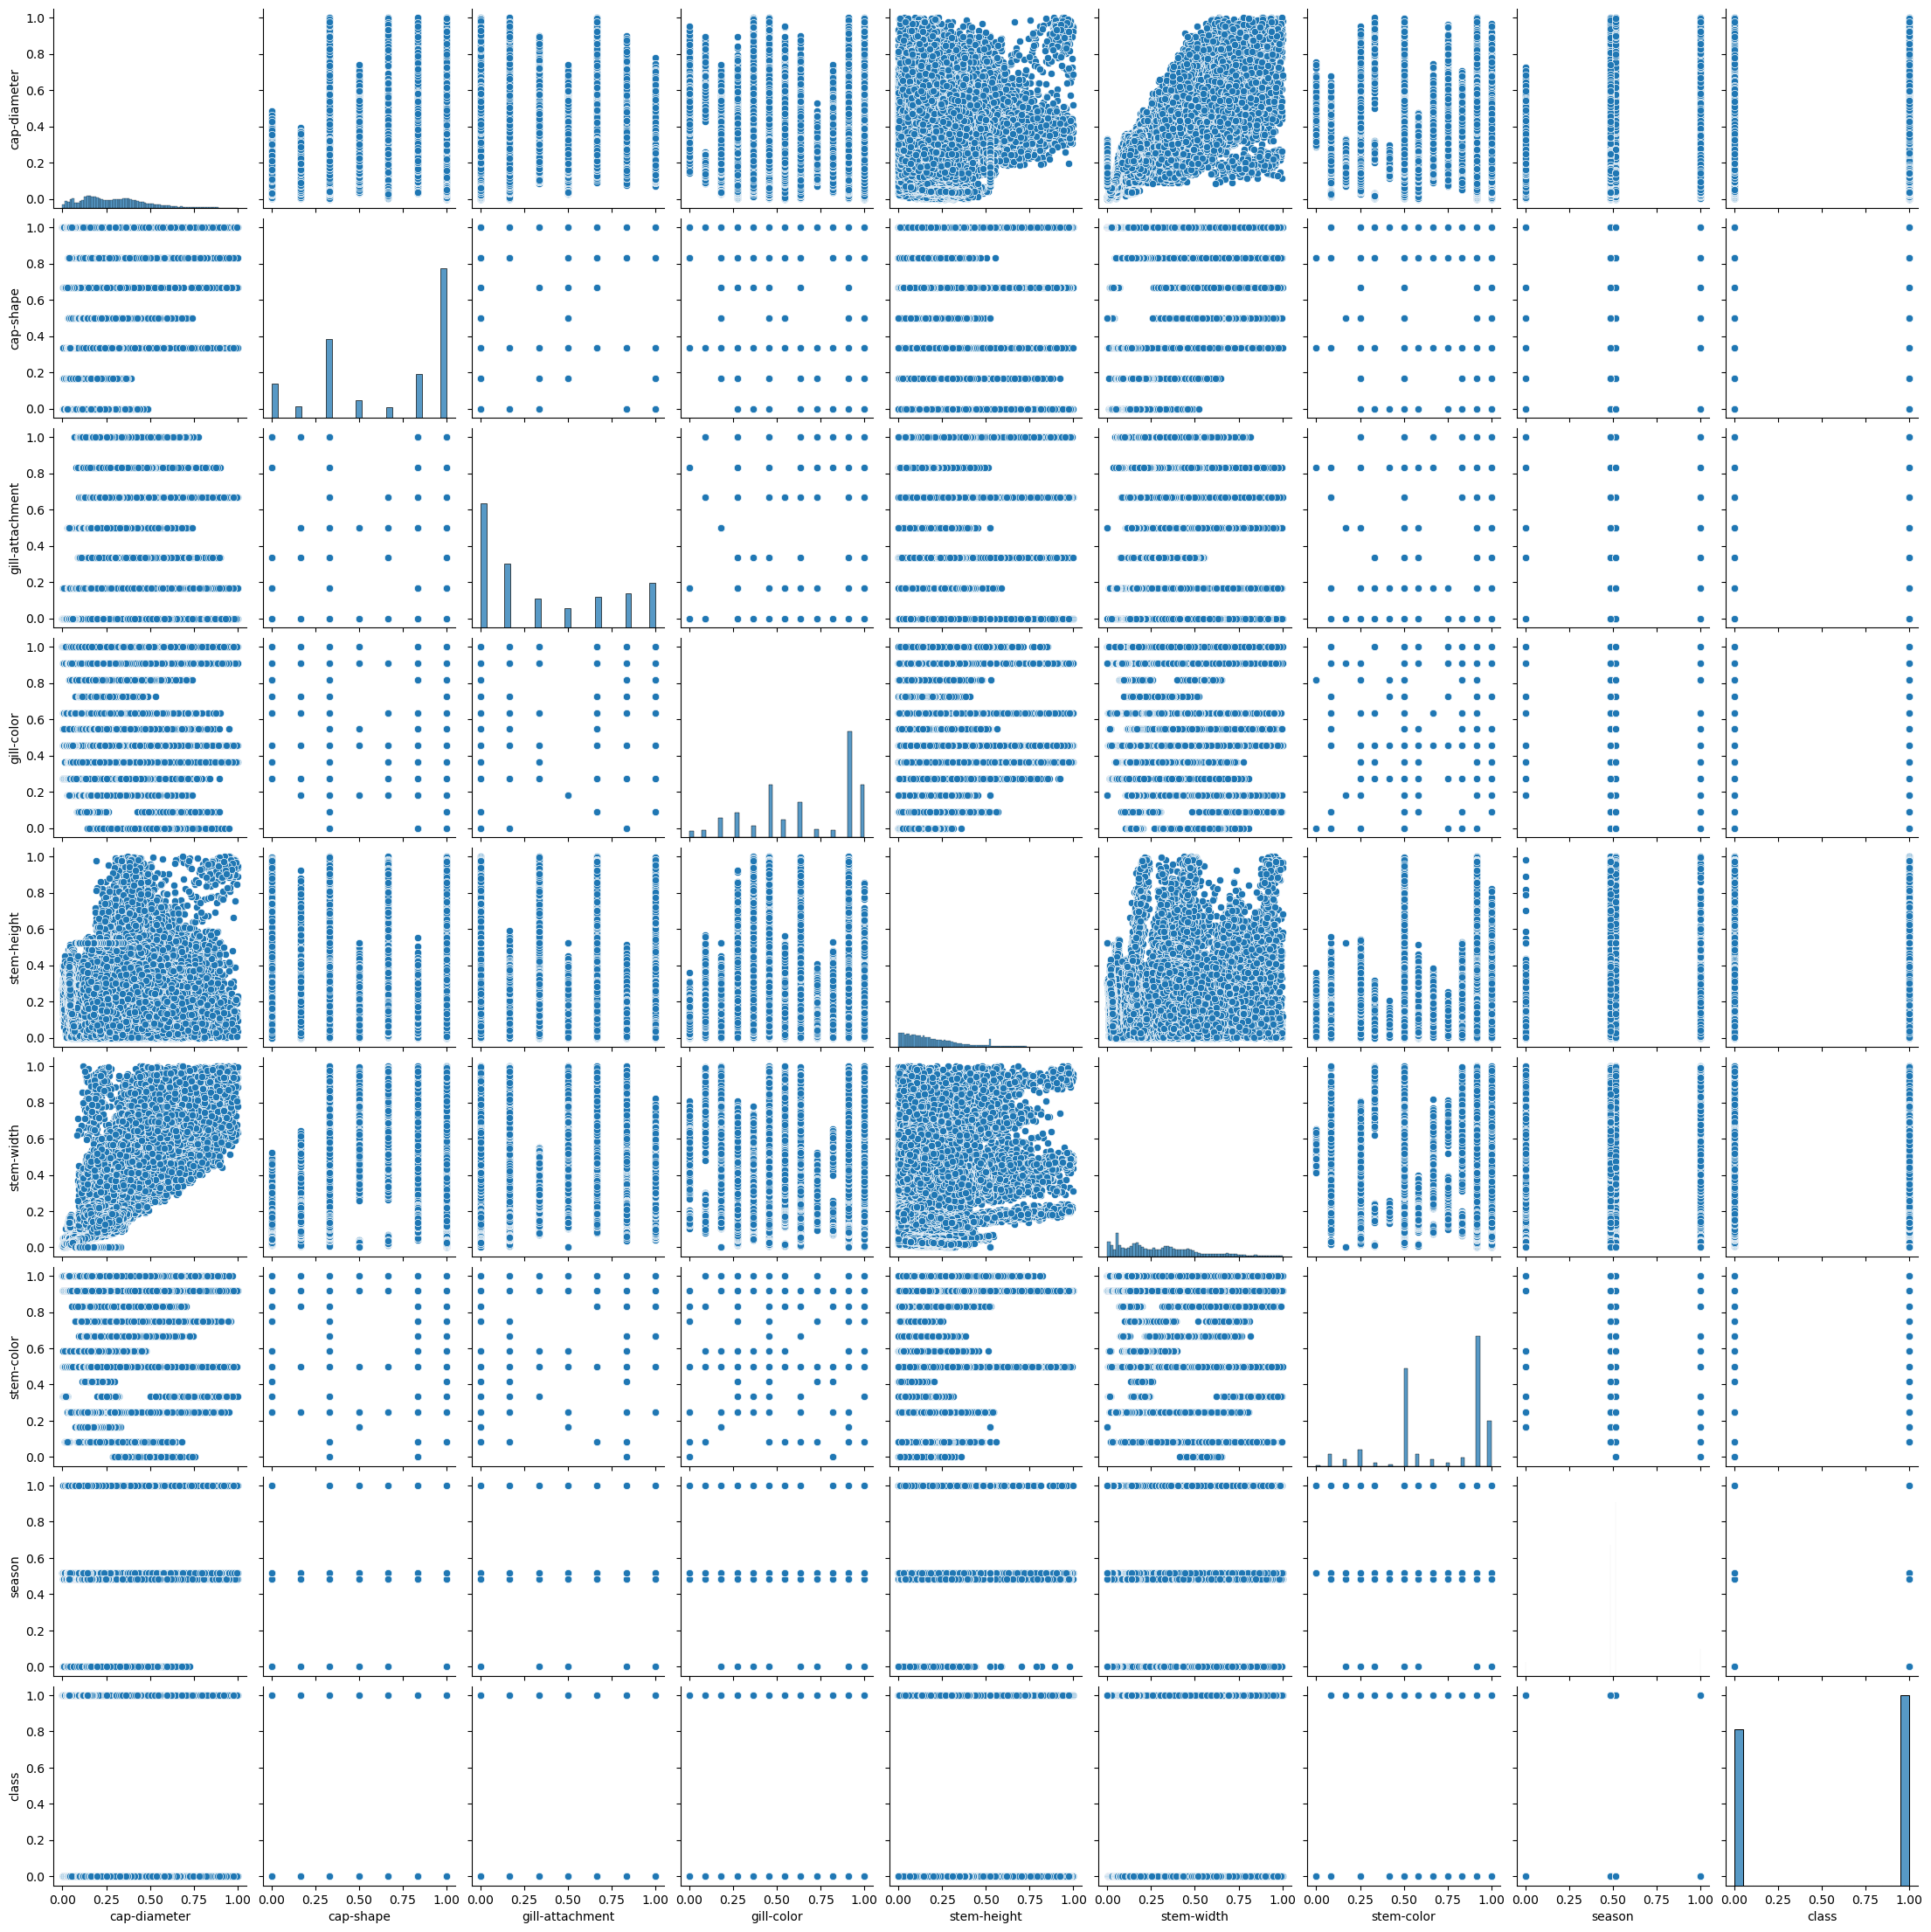

In [5]:
#plot pairplot of the dataset
sns.pairplot(df)
plt.show()

Split the set in test/validation/test datasets.

In [6]:
def divide_set(df , train_ratio , test_ratio , val_ratio = 0):
    print('Ratios:')
    print(f'Train: {train_ratio:.2f} , Vaidation {val_ratio:.2f} , Test: {test_ratio:.2f}')
    assert train_ratio + test_ratio + val_ratio ==1
    appo     = pd.DataFrame(df)
    train_df = appo.sample(frac = train_ratio)
    appo     = appo.drop(train_df.index)
    
    test_ratio /= 1-train_ratio 
    val_ratio  /= 1-train_ratio
    test_df     = appo.sample(frac = test_ratio)
    appo        = appo.drop(test_df.index)
    
    split   = {
        'train' : [train_df.drop(columns = 'class') , train_df['class']] ,
        'val'   : [appo.drop(columns = 'class')    , appo['class']] ,
        'test'  : [test_df.drop(columns = 'class') , test_df['class']]
    }

    return split

df_division = divide_set(df , 0.6 , 0.2  , 0.2)

Ratios:
Train: 0.60 , Vaidation 0.20 , Test: 0.20


## Create the Neural Network 

Create the first model and train to classify the mushrooms.

In [7]:
def create_model(init_nodes):
    model = keras.models.Sequential()
    nodes = init_nodes

    model.add(keras.layers.Dense(nodes , activation = 'relu' , input_shape = (8,) ))
    nodes *= 2
    model.add(keras.layers.Dense(nodes , activation = 'relu'))
    model.add(keras.layers.Dense(nodes , activation = 'relu'))
    nodes = int(nodes * .5)
    model.add(keras.layers.Dense(nodes , activation = 'relu'))
    nodes = max(int(nodes / 2) , 1)
    model.add(keras.layers.Dense(nodes , activation = 'relu'))
    nodes = max(int(nodes / 2) , 1)
    model.add(keras.layers.Dense(nodes , activation = 'relu'))
    model.add(keras.layers.Dense(2   , activation = 'softmax'))

    return model

model = create_model(16)
model.compile(optimizer = 'adam' ,
              loss      = keras.losses.SparseCategoricalCrossentropy() ,
              metrics = ['accuracy'])
model.summary()

/home/sergio/.local/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 2)              │            10 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,454 (9.59 KB)

 Trainable params: 2,454 (9.59 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
history = model.fit(df_division['train'][0].to_numpy() , df_division['train'][1].to_numpy() ,
                    validation_data = (df_division['val'][0].to_numpy() , df_division['val'][1].to_numpy()) ,
                    epochs = 100)

Epoch 1/100
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.6181 - loss: 0.6417 - val_accuracy: 0.7257 - val_loss: 0.5497
Epoch 2/100
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.7436 - loss: 0.5232 - val_accuracy: 0.7829 - val_loss: 0.4463
Epoch 3/100
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.7915 - loss: 0.4323 - val_accuracy: 0.8322 - val_loss: 0.3744
Epoch 4/100
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.8370 - loss: 0.3652 - val_accuracy: 0.8613 - val_loss: 0.3209
Epoch 5/100
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8643 - loss: 0.3188 - val_accuracy: 0.8918 - val_loss: 0.2633
Epoch 6/100
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.8858 - loss: 0.2673 - val_accuracy: 0.9025 - val_loss: 0.2399
Epoch 7/100
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - accuracy: 0.8997 - loss: 0.2395 - val_accuracy: 0.9067 - val_loss: 0.2312
Epoch 8/100
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.9105 -

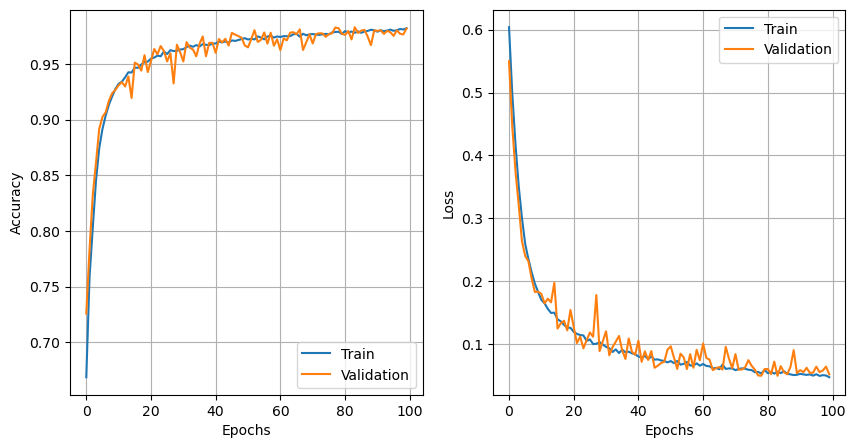

In [11]:
plt.figure(figsize = (10 , 5))

plt.subplot(1 , 2 , 1)

plt.plot(history.history['accuracy']     , label = 'Train')
plt.plot(history.history['val_accuracy'] , label = 'Validation')

plt.legend()
plt.grid()

plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1 , 2 , 2)

plt.plot(history.history['loss']     , label = 'Train')
plt.plot(history.history['val_loss'] , label = 'Validation')

plt.legend()
plt.grid()

plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

In [12]:
vals = model.evaluate(df_division['test'][0].to_numpy() , df_division['test'][1].to_numpy())

print(f"Accuracy {vals[1]*100:.1f} % , Loss {vals[0]:.3f}")

338/338 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9805 - loss: 0.0524
Accuracy 97.9 % , Loss 0.055


The NN converges quikly, I see that the accuracy reach around $90 \%$ in $5$ epochs.

This configuration is prety good, but, I want to study others configurations to find a better one.

## Hyperparamenter Optimization

To optimize the NN I studied the dependencies by:

1. The numbers of nodes in the first layers.
2. The learning rate.

In [50]:
import optuna
from optuna.visualization import plot_contour , plot_rank
from optuna.samplers import TPESampler
from optuna.importance import get_param_importances

In [59]:
def train(df , trial , ino , lr):
    model = create_model(trial.suggest_int('initial_nodes' , ino[0] , ino[1]))

    optimizer = keras.optimizers.Adam(learning_rate = trial.suggest_float('learning_rate' , lr[0] , lr[1] , log = True))
    model.compile(optimizer = optimizer ,
                  loss      = keras.losses.SparseCategoricalCrossentropy() ,
                  metrics   = ['accuracy'])

    model.fit(df['train'][0].to_numpy() , df['train'][1].to_numpy() ,
              validation_data = (df['val'][0].to_numpy() , df['val'][1].to_numpy()) ,
              epochs = 5)

    return model

In [60]:
def test(model , df):
    evaluation = model.evaluate(df['test'][0].to_numpy() , df['test'][1].to_numpy())

    return evaluation[1]

In [69]:
class Object:
    def __init__(self):
        self.ino = [16    , 100]
        self.lr  = [1e-10 , 1]

    def __call__(self,trial):
        model = train(df_division , trial , self.ino ,self.lr)
        score = test(model , df_division)

        return score
    
    def set_params(self , ino , lr):
        self.ino = ino
        self.lr  = lr

objective = Object()

In [37]:
sampler = TPESampler(seed = 0)
study   = optuna.create_study(direction = 'maximize' , sampler = sampler)
study.optimize(objective , n_trials = 30)

[I 2024-06-12 21:44:18,026] A new study created in memory with name: no-name-0f020090-f61a-4eea-9ac7-c1541509a5d3
/home/sergio/.local/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 25s 15ms/step - accuracy: 0.6802 - loss: 0.5754 - val_accuracy: 0.8682 - val_loss: 0.2987
Epoch 2/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.8737 - loss: 0.2844 - val_accuracy: 0.9216 - val_loss: 0.1815
Epoch 3/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.9165 - loss: 0.1941 - val_accuracy: 0.9315 - val_loss: 0.1701
Epoch 4/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.9392 - loss: 0.1500 - val_accuracy: 0.9468 - val_loss: 0.1375
Epoch 5/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.9505 - loss: 0.1274 - val_accuracy: 0.9569 - val_loss: 0.1001
338/338 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9613 - loss: 0.0959


[I 2024-06-12 21:45:52,737] Trial 0 finished with value: 0.959378182888031 and parameters: {'initial_nodes': 62, 'learning_rate': 0.0014187101103672111}. Best is trial 0 with value: 0.959378182888031.


Epoch 1/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 25s 16ms/step - accuracy: 0.5712 - loss: 0.6841 - val_accuracy: 0.6695 - val_loss: 0.6349
Epoch 2/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.6625 - loss: 0.6195 - val_accuracy: 0.6972 - val_loss: 0.5800
Epoch 3/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.6968 - loss: 0.5758 - val_accuracy: 0.7213 - val_loss: 0.5481
Epoch 4/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.7262 - loss: 0.5426 - val_accuracy: 0.7533 - val_loss: 0.5165
Epoch 5/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.7454 - loss: 0.5147 - val_accuracy: 0.7675 - val_loss: 0.4863
338/338 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7711 - loss: 0.4856


[I 2024-06-12 21:47:44,109] Trial 1 finished with value: 0.7660775184631348 and parameters: {'initial_nodes': 67, 'learning_rate': 2.8108122006183503e-05}. Best is trial 0 with value: 0.959378182888031.


Epoch 1/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 27s 14ms/step - accuracy: 0.6141 - loss: 0.6391 - val_accuracy: 0.7682 - val_loss: 0.4948
Epoch 2/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.7866 - loss: 0.4555 - val_accuracy: 0.8598 - val_loss: 0.3252
Epoch 3/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.8668 - loss: 0.3124 - val_accuracy: 0.9061 - val_loss: 0.2335
Epoch 4/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.9034 - loss: 0.2355 - val_accuracy: 0.9222 - val_loss: 0.1880
Epoch 5/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.9306 - loss: 0.1771 - val_accuracy: 0.9259 - val_loss: 0.1764
338/338 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9231 - loss: 0.1790


[I 2024-06-12 21:49:28,688] Trial 2 finished with value: 0.9216248989105225 and parameters: {'initial_nodes': 52, 'learning_rate': 0.0002877008405067789}. Best is trial 0 with value: 0.959378182888031.


Epoch 1/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 32s 18ms/step - accuracy: 0.5365 - loss: 0.8481 - val_accuracy: 0.5500 - val_loss: 0.6881
Epoch 2/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 24s 21ms/step - accuracy: 0.5364 - loss: 0.6916 - val_accuracy: 0.5500 - val_loss: 0.6922
Epoch 3/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.5362 - loss: 0.6926 - val_accuracy: 0.5500 - val_loss: 0.6905
Epoch 4/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.5304 - loss: 0.6935 - val_accuracy: 0.5500 - val_loss: 0.6882
Epoch 5/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - accuracy: 0.5258 - loss: 0.6939 - val_accuracy: 0.5500 - val_loss: 0.6891
338/338 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5434 - loss: 0.6910


[I 2024-06-12 21:51:14,826] Trial 3 finished with value: 0.5520495772361755 and parameters: {'initial_nodes': 53, 'learning_rate': 0.08274276086161435}. Best is trial 0 with value: 0.959378182888031.


Epoch 1/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 32s 20ms/step - accuracy: 0.5292 - loss: 0.6923 - val_accuracy: 0.5750 - val_loss: 0.6910
Epoch 2/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 36s 15ms/step - accuracy: 0.5595 - loss: 0.6908 - val_accuracy: 0.5527 - val_loss: 0.6894
Epoch 3/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 23s 17ms/step - accuracy: 0.5533 - loss: 0.6890 - val_accuracy: 0.5492 - val_loss: 0.6879
Epoch 4/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - accuracy: 0.5456 - loss: 0.6879 - val_accuracy: 0.5503 - val_loss: 0.6867
Epoch 5/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - accuracy: 0.5492 - loss: 0.6866 - val_accuracy: 0.5516 - val_loss: 0.6856
338/338 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5441 - loss: 0.6860


[I 2024-06-12 21:53:33,029] Trial 4 finished with value: 0.5543628931045532 and parameters: {'initial_nodes': 97, 'learning_rate': 6.829913261377663e-07}. Best is trial 0 with value: 0.959378182888031.


Epoch 1/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 27s 15ms/step - accuracy: 0.5683 - loss: 0.6843 - val_accuracy: 0.6280 - val_loss: 0.6503
Epoch 2/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.6474 - loss: 0.6405 - val_accuracy: 0.6636 - val_loss: 0.6109
Epoch 3/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.6703 - loss: 0.6023 - val_accuracy: 0.6751 - val_loss: 0.5880
Epoch 4/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - accuracy: 0.6794 - loss: 0.5823 - val_accuracy: 0.7020 - val_loss: 0.5628
Epoch 5/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.6977 - loss: 0.5598 - val_accuracy: 0.7176 - val_loss: 0.5391
338/338 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.7205 - loss: 0.5379


[I 2024-06-12 21:55:14,115] Trial 5 finished with value: 0.7155547142028809 and parameters: {'initial_nodes': 83, 'learning_rate': 1.9451325325217144e-05}. Best is trial 0 with value: 0.959378182888031.


Epoch 1/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.5333 - loss: 2.6170 - val_accuracy: 0.5500 - val_loss: 0.6915
Epoch 2/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.5273 - loss: 0.6941 - val_accuracy: 0.5500 - val_loss: 0.6894
Epoch 3/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.5275 - loss: 0.6963 - val_accuracy: 0.4500 - val_loss: 0.6933
Epoch 4/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.5258 - loss: 0.6949 - val_accuracy: 0.5500 - val_loss: 0.6888
Epoch 5/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.5262 - loss: 0.6964 - val_accuracy: 0.5500 - val_loss: 0.6887
338/338 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5434 - loss: 0.6896


[I 2024-06-12 21:56:48,322] Trial 6 finished with value: 0.5520495772361755 and parameters: {'initial_nodes': 64, 'learning_rate': 0.1802878181559545}. Best is trial 0 with value: 0.959378182888031.


Epoch 1/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 24s 14ms/step - accuracy: 0.5428 - loss: 0.6909 - val_accuracy: 0.5493 - val_loss: 0.6904
Epoch 2/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.5494 - loss: 0.6903 - val_accuracy: 0.5493 - val_loss: 0.6904
Epoch 3/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.5505 - loss: 0.6902 - val_accuracy: 0.5493 - val_loss: 0.6904
Epoch 4/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.5480 - loss: 0.6905 - val_accuracy: 0.5493 - val_loss: 0.6904
Epoch 5/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.5535 - loss: 0.6901 - val_accuracy: 0.5493 - val_loss: 0.6904
338/338 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5428 - loss: 0.6911


[I 2024-06-12 21:58:32,764] Trial 7 finished with value: 0.5514944195747375 and parameters: {'initial_nodes': 22, 'learning_rate': 7.435205853060182e-10}. Best is trial 0 with value: 0.959378182888031.


Epoch 1/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - accuracy: 0.6017 - loss: 0.6484 - val_accuracy: 0.6412 - val_loss: 0.6104
Epoch 2/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.6443 - loss: 0.6053 - val_accuracy: 0.5500 - val_loss: 0.6790
Epoch 3/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.6227 - loss: 0.6244 - val_accuracy: 0.6681 - val_loss: 0.5844
Epoch 4/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.6739 - loss: 0.5841 - val_accuracy: 0.6803 - val_loss: 0.5825
Epoch 5/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.6815 - loss: 0.5761 - val_accuracy: 0.7003 - val_loss: 0.5661
338/338 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7084 - loss: 0.5592


[I 2024-06-12 22:00:07,176] Trial 8 finished with value: 0.7037105560302734 and parameters: {'initial_nodes': 17, 'learning_rate': 0.021193293640885156}. Best is trial 0 with value: 0.959378182888031.


Epoch 1/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 26s 16ms/step - accuracy: 0.5368 - loss: 0.7567 - val_accuracy: 0.5500 - val_loss: 0.6905
Epoch 2/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.5480 - loss: 0.6898 - val_accuracy: 0.4500 - val_loss: 0.6963
Epoch 3/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - accuracy: 0.5367 - loss: 0.6911 - val_accuracy: 0.5500 - val_loss: 0.6885
Epoch 4/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.5414 - loss: 0.6909 - val_accuracy: 0.5500 - val_loss: 0.6882
Epoch 5/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.5478 - loss: 0.6895 - val_accuracy: 0.5500 - val_loss: 0.6883
338/338 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5434 - loss: 0.6894


[I 2024-06-12 22:01:47,534] Trial 9 finished with value: 0.5520495772361755 and parameters: {'initial_nodes': 82, 'learning_rate': 0.05013274471944537}. Best is trial 0 with value: 0.959378182888031.


Epoch 1/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - accuracy: 0.5314 - loss: 0.6927 - val_accuracy: 0.5311 - val_loss: 0.6926
Epoch 2/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.5350 - loss: 0.6925 - val_accuracy: 0.5331 - val_loss: 0.6925
Epoch 3/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.5385 - loss: 0.6923 - val_accuracy: 0.5340 - val_loss: 0.6925
Epoch 4/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.5337 - loss: 0.6926 - val_accuracy: 0.5362 - val_loss: 0.6924
Epoch 5/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 22s 16ms/step - accuracy: 0.5382 - loss: 0.6924 - val_accuracy: 0.5373 - val_loss: 0.6924
338/338 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5372 - loss: 0.6926


[I 2024-06-12 22:03:29,759] Trial 10 finished with value: 0.5423336625099182 and parameters: {'initial_nodes': 41, 'learning_rate': 4.803196156519616e-08}. Best is trial 0 with value: 0.959378182888031.


Epoch 1/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.6729 - loss: 0.5768 - val_accuracy: 0.8674 - val_loss: 0.3195
Epoch 2/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.8818 - loss: 0.2827 - val_accuracy: 0.9213 - val_loss: 0.1958
Epoch 3/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.9249 - loss: 0.1917 - val_accuracy: 0.9364 - val_loss: 0.1557
Epoch 4/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.9404 - loss: 0.1488 - val_accuracy: 0.9555 - val_loss: 0.1106
Epoch 5/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.9509 - loss: 0.1246 - val_accuracy: 0.9573 - val_loss: 0.1028
338/338 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9610 - loss: 0.1056


[I 2024-06-12 22:05:09,610] Trial 11 finished with value: 0.9565096497535706 and parameters: {'initial_nodes': 42, 'learning_rate': 0.0007478926092290461}. Best is trial 0 with value: 0.959378182888031.


Epoch 1/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 27s 16ms/step - accuracy: 0.6657 - loss: 0.5955 - val_accuracy: 0.7914 - val_loss: 0.4327
Epoch 2/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.8381 - loss: 0.3529 - val_accuracy: 0.9071 - val_loss: 0.2288
Epoch 3/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.9036 - loss: 0.2275 - val_accuracy: 0.9188 - val_loss: 0.2003
Epoch 4/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.9261 - loss: 0.1770 - val_accuracy: 0.9176 - val_loss: 0.1950
Epoch 5/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - accuracy: 0.9434 - loss: 0.1400 - val_accuracy: 0.9500 - val_loss: 0.1223
338/338 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9517 - loss: 0.1227


[I 2024-06-12 22:06:57,148] Trial 12 finished with value: 0.9488294720649719 and parameters: {'initial_nodes': 38, 'learning_rate': 0.0017024559225280243}. Best is trial 0 with value: 0.959378182888031.


Epoch 1/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - accuracy: 0.6479 - loss: 0.6263 - val_accuracy: 0.7867 - val_loss: 0.4672
Epoch 2/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.8002 - loss: 0.4296 - val_accuracy: 0.8616 - val_loss: 0.3111
Epoch 3/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.8673 - loss: 0.3021 - val_accuracy: 0.8964 - val_loss: 0.2395
Epoch 4/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 24s 16ms/step - accuracy: 0.9060 - loss: 0.2264 - val_accuracy: 0.9316 - val_loss: 0.1782
Epoch 5/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.9203 - loss: 0.1907 - val_accuracy: 0.9267 - val_loss: 0.1693
338/338 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9292 - loss: 0.1685


[I 2024-06-12 22:08:45,122] Trial 13 finished with value: 0.9253261685371399 and parameters: {'initial_nodes': 34, 'learning_rate': 0.0006267965690054416}. Best is trial 0 with value: 0.959378182888031.


Epoch 1/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - accuracy: 0.5489 - loss: 0.6893 - val_accuracy: 0.5500 - val_loss: 0.6879
Epoch 2/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 0.5481 - loss: 0.6879 - val_accuracy: 0.5500 - val_loss: 0.6868
Epoch 3/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - accuracy: 0.5457 - loss: 0.6872 - val_accuracy: 0.5500 - val_loss: 0.6859
Epoch 4/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.5503 - loss: 0.6859 - val_accuracy: 0.5500 - val_loss: 0.6850
Epoch 5/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.5484 - loss: 0.6852 - val_accuracy: 0.5500 - val_loss: 0.6842
338/338 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5434 - loss: 0.6852


[I 2024-06-12 22:10:18,876] Trial 14 finished with value: 0.5520495772361755 and parameters: {'initial_nodes': 70, 'learning_rate': 6.172893728485996e-07}. Best is trial 0 with value: 0.959378182888031.


Epoch 1/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.6527 - loss: 0.5963 - val_accuracy: 0.7918 - val_loss: 0.4150
Epoch 2/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.8177 - loss: 0.3726 - val_accuracy: 0.9104 - val_loss: 0.2246
Epoch 3/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.9007 - loss: 0.2271 - val_accuracy: 0.9019 - val_loss: 0.2524
Epoch 4/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - accuracy: 0.9312 - loss: 0.1637 - val_accuracy: 0.9405 - val_loss: 0.1416
Epoch 5/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.9435 - loss: 0.1354 - val_accuracy: 0.9419 - val_loss: 0.1400
338/338 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9439 - loss: 0.1432


[I 2024-06-12 22:11:57,165] Trial 15 finished with value: 0.9431849718093872 and parameters: {'initial_nodes': 47, 'learning_rate': 0.00270944148886398}. Best is trial 0 with value: 0.959378182888031.


Epoch 1/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - accuracy: 0.5250 - loss: 67.0287 - val_accuracy: 0.5500 - val_loss: 0.6912
Epoch 2/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.5265 - loss: 0.7070 - val_accuracy: 0.5500 - val_loss: 0.7070
Epoch 3/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.5231 - loss: 0.7060 - val_accuracy: 0.5500 - val_loss: 0.6912
Epoch 4/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.5158 - loss: 0.7083 - val_accuracy: 0.5500 - val_loss: 0.6930
Epoch 5/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.5158 - loss: 0.7065 - val_accuracy: 0.5500 - val_loss: 0.7043
338/338 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5434 - loss: 0.7080


[I 2024-06-12 22:13:35,205] Trial 16 finished with value: 0.5520495772361755 and parameters: {'initial_nodes': 27, 'learning_rate': 0.607045991608488}. Best is trial 0 with value: 0.959378182888031.


Epoch 1/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 29s 16ms/step - accuracy: 0.6242 - loss: 0.6561 - val_accuracy: 0.7404 - val_loss: 0.5496
Epoch 2/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.7533 - loss: 0.5220 - val_accuracy: 0.8037 - val_loss: 0.4466
Epoch 3/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.8126 - loss: 0.4230 - val_accuracy: 0.8403 - val_loss: 0.3675
Epoch 4/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.8493 - loss: 0.3430 - val_accuracy: 0.8648 - val_loss: 0.2964
Epoch 5/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.8752 - loss: 0.2809 - val_accuracy: 0.8855 - val_loss: 0.2526
338/338 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8936 - loss: 0.2454


[I 2024-06-12 22:15:23,111] Trial 17 finished with value: 0.8889608383178711 and parameters: {'initial_nodes': 59, 'learning_rate': 0.00011292562631566394}. Best is trial 0 with value: 0.959378182888031.


Epoch 1/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - accuracy: 0.5013 - loss: 0.6931 - val_accuracy: 0.6161 - val_loss: 0.6892
Epoch 2/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - accuracy: 0.6056 - loss: 0.6880 - val_accuracy: 0.5942 - val_loss: 0.6845
Epoch 3/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.5978 - loss: 0.6837 - val_accuracy: 0.6076 - val_loss: 0.6803
Epoch 4/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - accuracy: 0.6148 - loss: 0.6794 - val_accuracy: 0.6201 - val_loss: 0.6761
Epoch 5/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - accuracy: 0.6277 - loss: 0.6754 - val_accuracy: 0.6459 - val_loss: 0.6716
338/338 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6470 - loss: 0.6715


[I 2024-06-12 22:17:07,316] Trial 18 finished with value: 0.6461552977561951 and parameters: {'initial_nodes': 76, 'learning_rate': 2.2822312517983365e-06}. Best is trial 0 with value: 0.959378182888031.


Epoch 1/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - accuracy: 0.6086 - loss: 0.6355 - val_accuracy: 0.7164 - val_loss: 0.5206
Epoch 2/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.7115 - loss: 0.5352 - val_accuracy: 0.7542 - val_loss: 0.4815
Epoch 3/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.7540 - loss: 0.4815 - val_accuracy: 0.8300 - val_loss: 0.3692
Epoch 4/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.8295 - loss: 0.3619 - val_accuracy: 0.8755 - val_loss: 0.2722
Epoch 5/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.8786 - loss: 0.2746 - val_accuracy: 0.8620 - val_loss: 0.3795
338/338 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8649 - loss: 0.3558


[I 2024-06-12 22:18:46,380] Trial 19 finished with value: 0.8620338439941406 and parameters: {'initial_nodes': 31, 'learning_rate': 0.007063277779587926}. Best is trial 0 with value: 0.959378182888031.


Epoch 1/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - accuracy: 0.4569 - loss: 0.7027 - val_accuracy: 0.4500 - val_loss: 0.7041
Epoch 2/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.4519 - loss: 0.7041 - val_accuracy: 0.4500 - val_loss: 0.7040
Epoch 3/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.4517 - loss: 0.7038 - val_accuracy: 0.4500 - val_loss: 0.7039
Epoch 4/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.4550 - loss: 0.7031 - val_accuracy: 0.4500 - val_loss: 0.7039
Epoch 5/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.4527 - loss: 0.7038 - val_accuracy: 0.4500 - val_loss: 0.7038
338/338 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.4566 - loss: 0.7034


[I 2024-06-12 22:20:32,479] Trial 20 finished with value: 0.4479503929615021 and parameters: {'initial_nodes': 45, 'learning_rate': 1.4948023830692047e-08}. Best is trial 0 with value: 0.959378182888031.


Epoch 1/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - accuracy: 0.6836 - loss: 0.5885 - val_accuracy: 0.8507 - val_loss: 0.3371
Epoch 2/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.8636 - loss: 0.3152 - val_accuracy: 0.8903 - val_loss: 0.2623
Epoch 3/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.9125 - loss: 0.2148 - val_accuracy: 0.9062 - val_loss: 0.2123
Epoch 4/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.9366 - loss: 0.1614 - val_accuracy: 0.9433 - val_loss: 0.1465
Epoch 5/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.9469 - loss: 0.1363 - val_accuracy: 0.9529 - val_loss: 0.1269
338/338 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9486 - loss: 0.1287


[I 2024-06-12 22:22:22,678] Trial 21 finished with value: 0.9488294720649719 and parameters: {'initial_nodes': 39, 'learning_rate': 0.0009871325742695461}. Best is trial 0 with value: 0.959378182888031.


Epoch 1/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - accuracy: 0.6076 - loss: 0.6682 - val_accuracy: 0.6689 - val_loss: 0.5956
Epoch 2/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.6816 - loss: 0.5855 - val_accuracy: 0.7324 - val_loss: 0.5372
Epoch 3/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.7426 - loss: 0.5270 - val_accuracy: 0.7913 - val_loss: 0.4705
Epoch 4/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.7954 - loss: 0.4595 - val_accuracy: 0.8187 - val_loss: 0.4185
Epoch 5/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.8185 - loss: 0.4130 - val_accuracy: 0.8273 - val_loss: 0.3915
338/338 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8382 - loss: 0.3832


[I 2024-06-12 22:23:57,749] Trial 22 finished with value: 0.829092264175415 and parameters: {'initial_nodes': 56, 'learning_rate': 7.00176340082255e-05}. Best is trial 0 with value: 0.959378182888031.


Epoch 1/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - accuracy: 0.6588 - loss: 0.6007 - val_accuracy: 0.7979 - val_loss: 0.4341
Epoch 2/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.8070 - loss: 0.4094 - val_accuracy: 0.8409 - val_loss: 0.3260
Epoch 3/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.8609 - loss: 0.3023 - val_accuracy: 0.8898 - val_loss: 0.2347
Epoch 4/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.8987 - loss: 0.2381 - val_accuracy: 0.9134 - val_loss: 0.1919
Epoch 5/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.9204 - loss: 0.1923 - val_accuracy: 0.8994 - val_loss: 0.2233
338/338 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9017 - loss: 0.2235


[I 2024-06-12 22:25:41,394] Trial 23 finished with value: 0.8995095491409302 and parameters: {'initial_nodes': 35, 'learning_rate': 0.006205086125659256}. Best is trial 0 with value: 0.959378182888031.


Epoch 1/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 25s 16ms/step - accuracy: 0.6737 - loss: 0.5823 - val_accuracy: 0.8147 - val_loss: 0.3854
Epoch 2/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.8581 - loss: 0.3192 - val_accuracy: 0.9047 - val_loss: 0.2315
Epoch 3/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.9089 - loss: 0.2194 - val_accuracy: 0.9375 - val_loss: 0.1737
Epoch 4/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.9318 - loss: 0.1706 - val_accuracy: 0.9560 - val_loss: 0.1271
Epoch 5/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - accuracy: 0.9443 - loss: 0.1453 - val_accuracy: 0.9498 - val_loss: 0.1266
338/338 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9485 - loss: 0.1332


[I 2024-06-12 22:27:20,131] Trial 24 finished with value: 0.9483668208122253 and parameters: {'initial_nodes': 46, 'learning_rate': 0.0008468720754505352}. Best is trial 0 with value: 0.959378182888031.


Epoch 1/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 26s 16ms/step - accuracy: 0.5181 - loss: 0.6930 - val_accuracy: 0.6101 - val_loss: 0.6837
Epoch 2/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.6154 - loss: 0.6806 - val_accuracy: 0.6563 - val_loss: 0.6686
Epoch 3/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.6496 - loss: 0.6648 - val_accuracy: 0.6697 - val_loss: 0.6481
Epoch 4/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - accuracy: 0.6659 - loss: 0.6427 - val_accuracy: 0.6790 - val_loss: 0.6263
Epoch 5/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - accuracy: 0.6774 - loss: 0.6215 - val_accuracy: 0.6861 - val_loss: 0.6078
338/338 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6884 - loss: 0.6075


[I 2024-06-12 22:28:56,932] Trial 25 finished with value: 0.6842787265777588 and parameters: {'initial_nodes': 59, 'learning_rate': 9.577272494680547e-06}. Best is trial 0 with value: 0.959378182888031.


Epoch 1/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.6116 - loss: 0.6292 - val_accuracy: 0.6921 - val_loss: 0.5427
Epoch 2/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.7414 - loss: 0.4885 - val_accuracy: 0.8014 - val_loss: 0.4116
Epoch 3/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.8240 - loss: 0.3784 - val_accuracy: 0.8581 - val_loss: 0.3259
Epoch 4/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.8698 - loss: 0.2920 - val_accuracy: 0.8763 - val_loss: 0.2690
Epoch 5/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 22s 16ms/step - accuracy: 0.8821 - loss: 0.2559 - val_accuracy: 0.8974 - val_loss: 0.2438
338/338 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9066 - loss: 0.2225


[I 2024-06-12 22:30:25,209] Trial 26 finished with value: 0.9006199836730957 and parameters: {'initial_nodes': 49, 'learning_rate': 0.007627645270050743}. Best is trial 0 with value: 0.959378182888031.


Epoch 1/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 24s 14ms/step - accuracy: 0.5849 - loss: 0.6696 - val_accuracy: 0.7069 - val_loss: 0.5850
Epoch 2/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.7102 - loss: 0.5669 - val_accuracy: 0.7421 - val_loss: 0.5210
Epoch 3/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.7593 - loss: 0.5018 - val_accuracy: 0.7875 - val_loss: 0.4491
Epoch 4/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.8012 - loss: 0.4375 - val_accuracy: 0.8185 - val_loss: 0.3953
Epoch 5/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.8255 - loss: 0.3916 - val_accuracy: 0.8519 - val_loss: 0.3500
338/338 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8621 - loss: 0.3431


[I 2024-06-12 22:32:04,973] Trial 27 finished with value: 0.8537984490394592 and parameters: {'initial_nodes': 40, 'learning_rate': 0.00012363405031674045}. Best is trial 0 with value: 0.959378182888031.


Epoch 1/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 26s 15ms/step - accuracy: 0.5091 - loss: 20.0333 - val_accuracy: 0.5500 - val_loss: 0.6883
Epoch 2/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.5114 - loss: 0.7134 - val_accuracy: 0.5500 - val_loss: 0.7310
Epoch 3/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.5160 - loss: 0.7131 - val_accuracy: 0.5500 - val_loss: 0.7081
Epoch 4/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.5154 - loss: 0.7092 - val_accuracy: 0.5500 - val_loss: 0.6911
Epoch 5/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.5149 - loss: 0.7093 - val_accuracy: 0.5500 - val_loss: 0.7009
338/338 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5434 - loss: 0.7043


[I 2024-06-12 22:33:43,793] Trial 28 finished with value: 0.5520495772361755 and parameters: {'initial_nodes': 27, 'learning_rate': 0.7614898552485994}. Best is trial 0 with value: 0.959378182888031.


Epoch 1/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 27s 17ms/step - accuracy: 0.5432 - loss: 0.6897 - val_accuracy: 0.5602 - val_loss: 0.6818
Epoch 2/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.5711 - loss: 0.6796 - val_accuracy: 0.6050 - val_loss: 0.6695
Epoch 3/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 22s 16ms/step - accuracy: 0.6110 - loss: 0.6652 - val_accuracy: 0.6363 - val_loss: 0.6542
Epoch 4/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - accuracy: 0.6339 - loss: 0.6515 - val_accuracy: 0.6490 - val_loss: 0.6375
Epoch 5/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - accuracy: 0.6532 - loss: 0.6348 - val_accuracy: 0.6597 - val_loss: 0.6230
338/338 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6704 - loss: 0.6218


[I 2024-06-12 22:35:34,524] Trial 29 finished with value: 0.665031909942627 and parameters: {'initial_nodes': 67, 'learning_rate': 7.450188473832218e-06}. Best is trial 0 with value: 0.959378182888031.


In [51]:
fig = plot_contour(study)
fig.show()
fig = plot_rank(study)
fig.show()

/tmp/ipykernel_9877/3727773372.py:3: ExperimentalWarning:

plot_rank is experimental (supported from v3.2.0). The interface can change in the future.



In [52]:
importance = get_param_importances(study)
print(importance)

{'learning_rate': 0.8016279812093037, 'initial_nodes': 0.19837201879069627}


In [71]:
objective.set_params(ino = [16 , 100] ,
                     lr  = [0.0001 , 0.01])

In [72]:
study_opt = optuna.create_study(direction = 'maximize' , sampler = sampler)
study_opt.optimize(objective , n_trials = 30)

[I 2024-06-12 23:56:42,154] A new study created in memory with name: no-name-6beb837a-9257-49c0-94d0-4eb6ef7bdff1
/home/sergio/.local/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 54s 16ms/step - accuracy: 0.6656 - loss: 0.5887 - val_accuracy: 0.7966 - val_loss: 0.4058
Epoch 2/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.8324 - loss: 0.3740 - val_accuracy: 0.8953 - val_loss: 0.2529
Epoch 3/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.8912 - loss: 0.2529 - val_accuracy: 0.9371 - val_loss: 0.1580
Epoch 4/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.9279 - loss: 0.1787 - val_accuracy: 0.9271 - val_loss: 0.1746
Epoch 5/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.9389 - loss: 0.1516 - val_accuracy: 0.9592 - val_loss: 0.1002
338/338 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9626 - loss: 0.0958


[I 2024-06-12 23:58:53,041] Trial 0 finished with value: 0.9590080380439758 and parameters: {'initial_nodes': 55, 'learning_rate': 0.0036396393567863887}. Best is trial 0 with value: 0.9590080380439758.


Epoch 1/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 24s 14ms/step - accuracy: 0.6513 - loss: 0.6064 - val_accuracy: 0.8200 - val_loss: 0.3870
Epoch 2/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.8481 - loss: 0.3434 - val_accuracy: 0.8905 - val_loss: 0.2477
Epoch 3/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.8976 - loss: 0.2427 - val_accuracy: 0.9288 - val_loss: 0.1753
Epoch 4/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.9271 - loss: 0.1782 - val_accuracy: 0.9380 - val_loss: 0.1476
Epoch 5/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.9399 - loss: 0.1439 - val_accuracy: 0.9569 - val_loss: 0.1181
338/338 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9508 - loss: 0.1299


[I 2024-06-13 00:00:33,324] Trial 1 finished with value: 0.9491070508956909 and parameters: {'initial_nodes': 26, 'learning_rate': 0.001904767808428205}. Best is trial 0 with value: 0.9590080380439758.


Epoch 1/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - accuracy: 0.6463 - loss: 0.6184 - val_accuracy: 0.7148 - val_loss: 0.5159
Epoch 2/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.7586 - loss: 0.4638 - val_accuracy: 0.8079 - val_loss: 0.3996
Epoch 3/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.8206 - loss: 0.3638 - val_accuracy: 0.8717 - val_loss: 0.3067
Epoch 4/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.8785 - loss: 0.2706 - val_accuracy: 0.9234 - val_loss: 0.1868
Epoch 5/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.9131 - loss: 0.2063 - val_accuracy: 0.9300 - val_loss: 0.1670
338/338 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9333 - loss: 0.1670


[I 2024-06-13 00:02:17,614] Trial 2 finished with value: 0.9335615634918213 and parameters: {'initial_nodes': 28, 'learning_rate': 0.007750644796341917}. Best is trial 0 with value: 0.9590080380439758.


Epoch 1/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - accuracy: 0.6475 - loss: 0.6115 - val_accuracy: 0.8185 - val_loss: 0.4008
Epoch 2/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.8467 - loss: 0.3437 - val_accuracy: 0.9112 - val_loss: 0.2203
Epoch 3/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.9018 - loss: 0.2284 - val_accuracy: 0.9099 - val_loss: 0.2164
Epoch 4/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - accuracy: 0.9324 - loss: 0.1684 - val_accuracy: 0.9419 - val_loss: 0.1483
Epoch 5/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.9417 - loss: 0.1445 - val_accuracy: 0.9518 - val_loss: 0.1179
338/338 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9524 - loss: 0.1150


[I 2024-06-13 00:04:01,073] Trial 3 finished with value: 0.9502174258232117 and parameters: {'initial_nodes': 60, 'learning_rate': 0.0006750312521595928}. Best is trial 0 with value: 0.9590080380439758.


Epoch 1/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - accuracy: 0.6552 - loss: 0.6030 - val_accuracy: 0.7853 - val_loss: 0.4336
Epoch 2/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.8274 - loss: 0.3667 - val_accuracy: 0.8951 - val_loss: 0.2512
Epoch 3/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.8867 - loss: 0.2601 - val_accuracy: 0.9106 - val_loss: 0.2042
Epoch 4/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.9144 - loss: 0.2027 - val_accuracy: 0.9112 - val_loss: 0.2113
Epoch 5/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.9365 - loss: 0.1583 - val_accuracy: 0.9305 - val_loss: 0.1695
338/338 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9253 - loss: 0.1785


[I 2024-06-13 00:05:45,479] Trial 4 finished with value: 0.9231979250907898 and parameters: {'initial_nodes': 38, 'learning_rate': 0.003535634629148813}. Best is trial 0 with value: 0.9590080380439758.


Epoch 1/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.6711 - loss: 0.5823 - val_accuracy: 0.8514 - val_loss: 0.3283
Epoch 2/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.8694 - loss: 0.2948 - val_accuracy: 0.9127 - val_loss: 0.2019
Epoch 3/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.9211 - loss: 0.1940 - val_accuracy: 0.9246 - val_loss: 0.2096
Epoch 4/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.9409 - loss: 0.1494 - val_accuracy: 0.9486 - val_loss: 0.1284
Epoch 5/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.9508 - loss: 0.1239 - val_accuracy: 0.9494 - val_loss: 0.1277
338/338 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9491 - loss: 0.1327


[I 2024-06-13 00:07:20,133] Trial 5 finished with value: 0.9497547745704651 and parameters: {'initial_nodes': 54, 'learning_rate': 0.0013704648392849023}. Best is trial 0 with value: 0.9590080380439758.


Epoch 1/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - accuracy: 0.6424 - loss: 0.6054 - val_accuracy: 0.7718 - val_loss: 0.4647
Epoch 2/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accuracy: 0.7902 - loss: 0.4423 - val_accuracy: 0.8333 - val_loss: 0.3622
Epoch 3/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.8450 - loss: 0.3485 - val_accuracy: 0.8736 - val_loss: 0.2978
Epoch 4/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.8753 - loss: 0.2861 - val_accuracy: 0.8961 - val_loss: 0.2566
Epoch 5/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.9023 - loss: 0.2381 - val_accuracy: 0.9023 - val_loss: 0.2271
338/338 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9048 - loss: 0.2260


[I 2024-06-13 00:09:09,129] Trial 6 finished with value: 0.9015452861785889 and parameters: {'initial_nodes': 17, 'learning_rate': 0.0017189806743319388}. Best is trial 0 with value: 0.9590080380439758.


Epoch 1/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 24s 14ms/step - accuracy: 0.6746 - loss: 0.5796 - val_accuracy: 0.8183 - val_loss: 0.3921
Epoch 2/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.8613 - loss: 0.3070 - val_accuracy: 0.9133 - val_loss: 0.2069
Epoch 3/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.9172 - loss: 0.1890 - val_accuracy: 0.9456 - val_loss: 0.1300
Epoch 4/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.9334 - loss: 0.1610 - val_accuracy: 0.9595 - val_loss: 0.1088
Epoch 5/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.9522 - loss: 0.1177 - val_accuracy: 0.9540 - val_loss: 0.1110
338/338 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9570 - loss: 0.1039


[I 2024-06-13 00:10:52,472] Trial 7 finished with value: 0.956046998500824 and parameters: {'initial_nodes': 68, 'learning_rate': 0.0017134364197119662}. Best is trial 0 with value: 0.9590080380439758.


Epoch 1/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 27s 18ms/step - accuracy: 0.6764 - loss: 0.5760 - val_accuracy: 0.8537 - val_loss: 0.3151
Epoch 2/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.8692 - loss: 0.2869 - val_accuracy: 0.9223 - val_loss: 0.1818
Epoch 3/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.9214 - loss: 0.1930 - val_accuracy: 0.9367 - val_loss: 0.1584
Epoch 4/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.9406 - loss: 0.1456 - val_accuracy: 0.9667 - val_loss: 0.0885
Epoch 5/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - accuracy: 0.9507 - loss: 0.1252 - val_accuracy: 0.9583 - val_loss: 0.1088
338/338 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9599 - loss: 0.1150


[I 2024-06-13 00:12:29,317] Trial 8 finished with value: 0.9578050971031189 and parameters: {'initial_nodes': 96, 'learning_rate': 0.0023101522250182378}. Best is trial 0 with value: 0.9590080380439758.


Epoch 1/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 24s 14ms/step - accuracy: 0.6667 - loss: 0.5978 - val_accuracy: 0.8330 - val_loss: 0.3698
Epoch 2/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.8459 - loss: 0.3441 - val_accuracy: 0.9108 - val_loss: 0.2275
Epoch 3/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.9101 - loss: 0.2179 - val_accuracy: 0.9027 - val_loss: 0.2277
Epoch 4/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.9347 - loss: 0.1605 - val_accuracy: 0.9571 - val_loss: 0.1164
Epoch 5/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.9455 - loss: 0.1344 - val_accuracy: 0.9364 - val_loss: 0.1523
338/338 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9422 - loss: 0.1453


[I 2024-06-13 00:13:54,041] Trial 9 finished with value: 0.9391135573387146 and parameters: {'initial_nodes': 46, 'learning_rate': 0.0007482796037620795}. Best is trial 0 with value: 0.9590080380439758.


Epoch 1/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - accuracy: 0.6231 - loss: 0.6423 - val_accuracy: 0.7418 - val_loss: 0.5184
Epoch 2/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.7680 - loss: 0.4880 - val_accuracy: 0.8270 - val_loss: 0.3973
Epoch 3/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.8373 - loss: 0.3742 - val_accuracy: 0.8629 - val_loss: 0.3132
Epoch 4/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.8738 - loss: 0.2915 - val_accuracy: 0.9052 - val_loss: 0.2383
Epoch 5/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.8997 - loss: 0.2426 - val_accuracy: 0.9176 - val_loss: 0.2071
338/338 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9246 - loss: 0.1981


[I 2024-06-13 00:15:32,668] Trial 10 finished with value: 0.919033944606781 and parameters: {'initial_nodes': 79, 'learning_rate': 0.00012425925928688687}. Best is trial 0 with value: 0.9590080380439758.


Epoch 1/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 26s 16ms/step - accuracy: 0.6507 - loss: 0.6057 - val_accuracy: 0.7836 - val_loss: 0.4400
Epoch 2/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.8109 - loss: 0.4059 - val_accuracy: 0.8553 - val_loss: 0.3117
Epoch 3/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.8773 - loss: 0.2782 - val_accuracy: 0.8832 - val_loss: 0.2666
Epoch 4/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.9085 - loss: 0.2148 - val_accuracy: 0.9289 - val_loss: 0.1691
Epoch 5/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.9321 - loss: 0.1693 - val_accuracy: 0.9464 - val_loss: 0.1315
338/338 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9493 - loss: 0.1272


[I 2024-06-13 00:17:24,327] Trial 11 finished with value: 0.9468863010406494 and parameters: {'initial_nodes': 99, 'learning_rate': 0.006396390531313276}. Best is trial 0 with value: 0.9590080380439758.


Epoch 1/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 26s 17ms/step - accuracy: 0.6545 - loss: 0.5894 - val_accuracy: 0.8341 - val_loss: 0.3779
Epoch 2/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - accuracy: 0.8466 - loss: 0.3362 - val_accuracy: 0.8752 - val_loss: 0.2769
Epoch 3/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - accuracy: 0.8963 - loss: 0.2375 - val_accuracy: 0.9145 - val_loss: 0.1869
Epoch 4/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.9199 - loss: 0.1864 - val_accuracy: 0.9159 - val_loss: 0.1958
Epoch 5/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.9367 - loss: 0.1535 - val_accuracy: 0.9520 - val_loss: 0.1164
338/338 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9506 - loss: 0.1233


[I 2024-06-13 00:19:07,320] Trial 12 finished with value: 0.9487369060516357 and parameters: {'initial_nodes': 98, 'learning_rate': 0.0038568260296892353}. Best is trial 0 with value: 0.9590080380439758.


Epoch 1/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 25s 16ms/step - accuracy: 0.6412 - loss: 0.6239 - val_accuracy: 0.7784 - val_loss: 0.4662
Epoch 2/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.8081 - loss: 0.4242 - val_accuracy: 0.8708 - val_loss: 0.3148
Epoch 3/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.8796 - loss: 0.2852 - val_accuracy: 0.8683 - val_loss: 0.2967
Epoch 4/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 24s 16ms/step - accuracy: 0.9125 - loss: 0.2177 - val_accuracy: 0.9310 - val_loss: 0.1743
Epoch 5/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.9340 - loss: 0.1705 - val_accuracy: 0.9296 - val_loss: 0.1742
338/338 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9278 - loss: 0.1700


[I 2024-06-13 00:20:54,637] Trial 13 finished with value: 0.9256037473678589 and parameters: {'initial_nodes': 80, 'learning_rate': 0.00018200349429556276}. Best is trial 0 with value: 0.9590080380439758.


Epoch 1/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - accuracy: 0.6625 - loss: 0.6067 - val_accuracy: 0.8318 - val_loss: 0.3927
Epoch 2/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.8462 - loss: 0.3483 - val_accuracy: 0.8954 - val_loss: 0.2419
Epoch 3/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.9086 - loss: 0.2245 - val_accuracy: 0.9417 - val_loss: 0.1503
Epoch 4/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.9377 - loss: 0.1626 - val_accuracy: 0.9409 - val_loss: 0.1509
Epoch 5/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 22s 16ms/step - accuracy: 0.9509 - loss: 0.1271 - val_accuracy: 0.9549 - val_loss: 0.1140
338/338 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9552 - loss: 0.1163


[I 2024-06-13 00:22:47,072] Trial 14 finished with value: 0.9538262486457825 and parameters: {'initial_nodes': 80, 'learning_rate': 0.00036075587924255635}. Best is trial 0 with value: 0.9590080380439758.


Epoch 1/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - accuracy: 0.6465 - loss: 0.5993 - val_accuracy: 0.7847 - val_loss: 0.4544
Epoch 2/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.8305 - loss: 0.3604 - val_accuracy: 0.8949 - val_loss: 0.2328
Epoch 3/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 22s 16ms/step - accuracy: 0.9047 - loss: 0.2242 - val_accuracy: 0.9130 - val_loss: 0.1907
Epoch 4/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.9236 - loss: 0.1783 - val_accuracy: 0.9401 - val_loss: 0.1578
Epoch 5/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.9414 - loss: 0.1436 - val_accuracy: 0.9330 - val_loss: 0.1837
338/338 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9342 - loss: 0.1835


[I 2024-06-13 00:24:38,998] Trial 15 finished with value: 0.9300453662872314 and parameters: {'initial_nodes': 65, 'learning_rate': 0.0035634365898049884}. Best is trial 0 with value: 0.9590080380439758.


Epoch 1/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 26s 17ms/step - accuracy: 0.6612 - loss: 0.5962 - val_accuracy: 0.7635 - val_loss: 0.4536
Epoch 2/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.8162 - loss: 0.3867 - val_accuracy: 0.8866 - val_loss: 0.2676
Epoch 3/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.8926 - loss: 0.2490 - val_accuracy: 0.9021 - val_loss: 0.2410
Epoch 4/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.9241 - loss: 0.1858 - val_accuracy: 0.9392 - val_loss: 0.1320
Epoch 5/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.9392 - loss: 0.1504 - val_accuracy: 0.9052 - val_loss: 0.2565
338/338 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9037 - loss: 0.2636


[I 2024-06-13 00:26:26,825] Trial 16 finished with value: 0.903118371963501 and parameters: {'initial_nodes': 89, 'learning_rate': 0.004898173158182574}. Best is trial 0 with value: 0.9590080380439758.


Epoch 1/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.6673 - loss: 0.5881 - val_accuracy: 0.8309 - val_loss: 0.3558
Epoch 2/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.8504 - loss: 0.3216 - val_accuracy: 0.8933 - val_loss: 0.2643
Epoch 3/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.9035 - loss: 0.2172 - val_accuracy: 0.9389 - val_loss: 0.1518
Epoch 4/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.9299 - loss: 0.1677 - val_accuracy: 0.9591 - val_loss: 0.1093
Epoch 5/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.9504 - loss: 0.1287 - val_accuracy: 0.9454 - val_loss: 0.1503
338/338 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9483 - loss: 0.1368


[I 2024-06-13 00:28:02,522] Trial 17 finished with value: 0.9467012286186218 and parameters: {'initial_nodes': 48, 'learning_rate': 0.00304590611041762}. Best is trial 0 with value: 0.9590080380439758.


Epoch 1/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - accuracy: 0.6435 - loss: 0.6217 - val_accuracy: 0.7302 - val_loss: 0.5070
Epoch 2/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.7583 - loss: 0.4767 - val_accuracy: 0.8366 - val_loss: 0.3576
Epoch 3/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.8377 - loss: 0.3617 - val_accuracy: 0.8470 - val_loss: 0.3516
Epoch 4/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.8672 - loss: 0.3000 - val_accuracy: 0.8847 - val_loss: 0.2643
Epoch 5/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.8841 - loss: 0.2655 - val_accuracy: 0.8674 - val_loss: 0.2767
338/338 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8776 - loss: 0.2732


[I 2024-06-13 00:29:26,759] Trial 18 finished with value: 0.8730452656745911 and parameters: {'initial_nodes': 74, 'learning_rate': 0.008503802955588271}. Best is trial 0 with value: 0.9590080380439758.


Epoch 1/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.6607 - loss: 0.5935 - val_accuracy: 0.8559 - val_loss: 0.3437
Epoch 2/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.8635 - loss: 0.3135 - val_accuracy: 0.9059 - val_loss: 0.2163
Epoch 3/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.9194 - loss: 0.1959 - val_accuracy: 0.9386 - val_loss: 0.1538
Epoch 4/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.9374 - loss: 0.1545 - val_accuracy: 0.9340 - val_loss: 0.1542
Epoch 5/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.9532 - loss: 0.1204 - val_accuracy: 0.9552 - val_loss: 0.1165
338/338 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9537 - loss: 0.1142


[I 2024-06-13 00:31:06,326] Trial 19 finished with value: 0.9525307416915894 and parameters: {'initial_nodes': 88, 'learning_rate': 0.00042911861799233204}. Best is trial 0 with value: 0.9590080380439758.


Epoch 1/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - accuracy: 0.6740 - loss: 0.5844 - val_accuracy: 0.8317 - val_loss: 0.3627
Epoch 2/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.8662 - loss: 0.3034 - val_accuracy: 0.9077 - val_loss: 0.2171
Epoch 3/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.9124 - loss: 0.2070 - val_accuracy: 0.9218 - val_loss: 0.1763
Epoch 4/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.9346 - loss: 0.1573 - val_accuracy: 0.9522 - val_loss: 0.1217
Epoch 5/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.9442 - loss: 0.1379 - val_accuracy: 0.9596 - val_loss: 0.1067
338/338 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9601 - loss: 0.1086


[I 2024-06-13 00:32:29,316] Trial 20 finished with value: 0.9562320709228516 and parameters: {'initial_nodes': 39, 'learning_rate': 0.00228428188747262}. Best is trial 0 with value: 0.9590080380439758.


Epoch 1/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.6795 - loss: 0.5725 - val_accuracy: 0.8445 - val_loss: 0.3436
Epoch 2/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.8651 - loss: 0.3079 - val_accuracy: 0.8738 - val_loss: 0.2900
Epoch 3/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.9137 - loss: 0.2129 - val_accuracy: 0.9292 - val_loss: 0.1682
Epoch 4/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.9330 - loss: 0.1655 - val_accuracy: 0.9427 - val_loss: 0.1381
Epoch 5/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.9438 - loss: 0.1392 - val_accuracy: 0.9558 - val_loss: 0.1154
338/338 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9579 - loss: 0.1085


[I 2024-06-13 00:34:04,806] Trial 21 finished with value: 0.955769419670105 and parameters: {'initial_nodes': 39, 'learning_rate': 0.0024982803087779163}. Best is trial 0 with value: 0.9590080380439758.


Epoch 1/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.6668 - loss: 0.5953 - val_accuracy: 0.8339 - val_loss: 0.3670
Epoch 2/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.8555 - loss: 0.3235 - val_accuracy: 0.9026 - val_loss: 0.2274
Epoch 3/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.9010 - loss: 0.2282 - val_accuracy: 0.8906 - val_loss: 0.2542
Epoch 4/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 0.9301 - loss: 0.1733 - val_accuracy: 0.9433 - val_loss: 0.1513
Epoch 5/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.9445 - loss: 0.1405 - val_accuracy: 0.9473 - val_loss: 0.1284
338/338 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9475 - loss: 0.1266


[I 2024-06-13 00:35:32,698] Trial 22 finished with value: 0.9453132152557373 and parameters: {'initial_nodes': 52, 'learning_rate': 0.000901742948522977}. Best is trial 0 with value: 0.9590080380439758.


Epoch 1/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.6649 - loss: 0.5979 - val_accuracy: 0.8548 - val_loss: 0.3396
Epoch 2/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8596 - loss: 0.3240 - val_accuracy: 0.9146 - val_loss: 0.2065
Epoch 3/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9126 - loss: 0.2157 - val_accuracy: 0.9262 - val_loss: 0.1756
Epoch 4/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9398 - loss: 0.1536 - val_accuracy: 0.9347 - val_loss: 0.1571
Epoch 5/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9472 - loss: 0.1335 - val_accuracy: 0.9620 - val_loss: 0.0999
338/338 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9600 - loss: 0.1009


[I 2024-06-13 00:36:39,151] Trial 23 finished with value: 0.9583603143692017 and parameters: {'initial_nodes': 40, 'learning_rate': 0.0012432946528130834}. Best is trial 0 with value: 0.9590080380439758.


Epoch 1/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.6949 - loss: 0.5554 - val_accuracy: 0.8704 - val_loss: 0.2904
Epoch 2/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.8788 - loss: 0.2724 - val_accuracy: 0.9179 - val_loss: 0.1995
Epoch 3/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.9243 - loss: 0.1795 - val_accuracy: 0.9191 - val_loss: 0.1887
Epoch 4/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accuracy: 0.9413 - loss: 0.1454 - val_accuracy: 0.9403 - val_loss: 0.1406
Epoch 5/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.9504 - loss: 0.1233 - val_accuracy: 0.9655 - val_loss: 0.0928
338/338 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9648 - loss: 0.0910


[I 2024-06-13 00:38:15,844] Trial 24 finished with value: 0.9624317288398743 and parameters: {'initial_nodes': 61, 'learning_rate': 0.0011258899562110714}. Best is trial 24 with value: 0.9624317288398743.


Epoch 1/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - accuracy: 0.6593 - loss: 0.5950 - val_accuracy: 0.8070 - val_loss: 0.3982
Epoch 2/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.8519 - loss: 0.3330 - val_accuracy: 0.9070 - val_loss: 0.2249
Epoch 3/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9178 - loss: 0.1969 - val_accuracy: 0.9510 - val_loss: 0.1266
Epoch 4/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.9460 - loss: 0.1378 - val_accuracy: 0.9564 - val_loss: 0.1078
Epoch 5/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.9544 - loss: 0.1151 - val_accuracy: 0.9505 - val_loss: 0.1231
338/338 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9533 - loss: 0.1222


[I 2024-06-13 00:39:26,589] Trial 25 finished with value: 0.9498473405838013 and parameters: {'initial_nodes': 59, 'learning_rate': 0.0010908194527846}. Best is trial 24 with value: 0.9624317288398743.


Epoch 1/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.6499 - loss: 0.6128 - val_accuracy: 0.8002 - val_loss: 0.4464
Epoch 2/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - accuracy: 0.8100 - loss: 0.4122 - val_accuracy: 0.8809 - val_loss: 0.2754
Epoch 3/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.8806 - loss: 0.2754 - val_accuracy: 0.9011 - val_loss: 0.2328
Epoch 4/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.9233 - loss: 0.1942 - val_accuracy: 0.9481 - val_loss: 0.1455
Epoch 5/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.9486 - loss: 0.1408 - val_accuracy: 0.9365 - val_loss: 0.1632
338/338 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9320 - loss: 0.1675


[I 2024-06-13 00:41:04,598] Trial 26 finished with value: 0.9332839846611023 and parameters: {'initial_nodes': 45, 'learning_rate': 0.0005390858530013509}. Best is trial 24 with value: 0.9624317288398743.


Epoch 1/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 25s 15ms/step - accuracy: 0.6213 - loss: 0.6629 - val_accuracy: 0.6680 - val_loss: 0.5884
Epoch 2/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - accuracy: 0.7301 - loss: 0.5353 - val_accuracy: 0.7764 - val_loss: 0.4736
Epoch 3/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.7881 - loss: 0.4556 - val_accuracy: 0.8197 - val_loss: 0.3970
Epoch 4/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.8335 - loss: 0.3762 - val_accuracy: 0.8414 - val_loss: 0.3577
Epoch 5/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.8615 - loss: 0.3246 - val_accuracy: 0.8821 - val_loss: 0.2866
338/338 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8926 - loss: 0.2735


[I 2024-06-13 00:42:48,740] Trial 27 finished with value: 0.8866475224494934 and parameters: {'initial_nodes': 30, 'learning_rate': 0.0002721646320781404}. Best is trial 24 with value: 0.9624317288398743.


Epoch 1/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.6764 - loss: 0.5878 - val_accuracy: 0.8377 - val_loss: 0.3445
Epoch 2/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.8684 - loss: 0.2923 - val_accuracy: 0.9176 - val_loss: 0.1981
Epoch 3/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.9229 - loss: 0.1886 - val_accuracy: 0.9493 - val_loss: 0.1229
Epoch 4/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.9438 - loss: 0.1363 - val_accuracy: 0.9570 - val_loss: 0.1147
Epoch 5/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - accuracy: 0.9551 - loss: 0.1125 - val_accuracy: 0.9622 - val_loss: 0.1032
338/338 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9550 - loss: 0.1122


[I 2024-06-13 00:44:31,086] Trial 28 finished with value: 0.9533635377883911 and parameters: {'initial_nodes': 66, 'learning_rate': 0.0012978173642321854}. Best is trial 24 with value: 0.9624317288398743.


Epoch 1/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.6470 - loss: 0.6063 - val_accuracy: 0.7519 - val_loss: 0.4980
Epoch 2/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.7789 - loss: 0.4672 - val_accuracy: 0.8298 - val_loss: 0.4031
Epoch 3/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.8529 - loss: 0.3478 - val_accuracy: 0.9064 - val_loss: 0.2400
Epoch 4/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.8991 - loss: 0.2454 - val_accuracy: 0.9244 - val_loss: 0.1945
Epoch 5/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.9217 - loss: 0.1981 - val_accuracy: 0.9286 - val_loss: 0.1824
338/338 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9281 - loss: 0.1838


[I 2024-06-13 00:45:56,256] Trial 29 finished with value: 0.9268066883087158 and parameters: {'initial_nodes': 34, 'learning_rate': 0.005024266990206464}. Best is trial 24 with value: 0.9624317288398743.


In [74]:
fig = plot_contour(study_opt)
fig.show()
fig = plot_rank(study_opt)
fig.show()

/tmp/ipykernel_9877/3440074610.py:3: ExperimentalWarning:

plot_rank is experimental (supported from v3.2.0). The interface can change in the future.



In [77]:
importance = get_param_importances(study_opt)
print(importance)

{'learning_rate': 0.7595883672415908, 'initial_nodes': 0.2404116327584091}


### Hyperopt

In [11]:
import hyperopt
from hyperopt import hp , tpe , STATUS_OK , Trials , fmin , space_eval

In [14]:
def train(df , params):
    model = create_model(params['init_nodes'])

    optimizer = keras.optimizers.Adam(learning_rate = params['leran_rate'])
    model.compile(optimizer = optimizer ,
                  loss      = keras.losses.SparseCategoricalCrossentropy() ,
                  metrics   = ['accuracy'])

    model.fit(df['train'][0].to_numpy() , df['train'][1].to_numpy() ,
              validation_data = (df['val'][0].to_numpy() , df['val'][1].to_numpy()) ,
              epochs = 5)

    return model

init_params={'init_nodes' : 16 ,
             'leran_rate' : .2}

model = train(df_division , init_params)

/home/sergio/.local/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 26s 18ms/step - accuracy: 0.5237 - loss: 0.7389 - val_accuracy: 0.4500 - val_loss: 0.7057
Epoch 2/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - accuracy: 0.5202 - loss: 0.6982 - val_accuracy: 0.4500 - val_loss: 0.7324
Epoch 3/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.5231 - loss: 0.6974 - val_accuracy: 0.4500 - val_loss: 0.7146
Epoch 4/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 22s 21ms/step - accuracy: 0.5286 - loss: 0.6944 - val_accuracy: 0.5500 - val_loss: 0.6887
Epoch 5/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - accuracy: 0.5260 - loss: 0.6957 - val_accuracy: 0.5500 - val_loss: 0.6967


In [13]:
def test(model , df):
    evaluation = model.evaluate(df['test'][0].to_numpy() , df['test'][1].to_numpy())

    return evaluation[1]

test(model , df_division)

338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5447 - loss: 0.6914


0.5456648468971252

In [14]:
def hyper_function(params):
    model    = train(df_division , params)
    test_acc = test(model , df_division)

    return {'loss'   : -test_acc ,
            'status' : STATUS_OK}

hyper_function(init_params)

Epoch 1/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.5316 - loss: 0.8766 - val_accuracy: 0.4514 - val_loss: 0.7020
Epoch 2/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5258 - loss: 0.6952 - val_accuracy: 0.5486 - val_loss: 0.6900
Epoch 3/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.5371 - loss: 0.6947 - val_accuracy: 0.5486 - val_loss: 0.6962
Epoch 4/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.5280 - loss: 0.6948 - val_accuracy: 0.5486 - val_loss: 0.6885
Epoch 5/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.5338 - loss: 0.6942 - val_accuracy: 0.4514 - val_loss: 0.6956
338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4553 - loss: 0.6954


{'loss': -0.45433515310287476, 'status': 'ok'}

In [21]:
search_space = {'init_nodes' : hp.randint('init_nodes' , 16 , 50) ,
                'leran_rate' : hp.loguniform('leran_rate' , -10 , 0)}

trials = Trials()

In [22]:
best = fmin(hyper_function ,
           space     = search_space ,
           algo      = tpe.suggest ,
           trials    = trials ,
           max_evals = 50 ,
           show_progressbar = False)

Epoch 1/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - accuracy: 0.5307 - loss: 0.6969 - val_accuracy: 0.5486 - val_loss: 0.6907
Epoch 2/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.5296 - loss: 0.6929 - val_accuracy: 0.5486 - val_loss: 0.6902
Epoch 3/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.5406 - loss: 0.6916 - val_accuracy: 0.5486 - val_loss: 0.6935
Epoch 4/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.5401 - loss: 0.6934 - val_accuracy: 0.5486 - val_loss: 0.7102
Epoch 5/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.5369 - loss: 0.6927 - val_accuracy: 0.5486 - val_loss: 0.6920
338/338 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5447 - loss: 0.6921
Epoch 1/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 23s 17ms/step - accuracy: 0.5344 - loss: 0.8060 - val_accuracy: 0.5486 - val_loss: 0.6896
Epoch 2/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.5415 - loss: 0.6918 - val_accuracy: 0.5486 - val_loss: 0.6888
Epoch 3/

In [1]:
print(space_eval(search_space , best))

NameError: name 'space_eval' is not defined

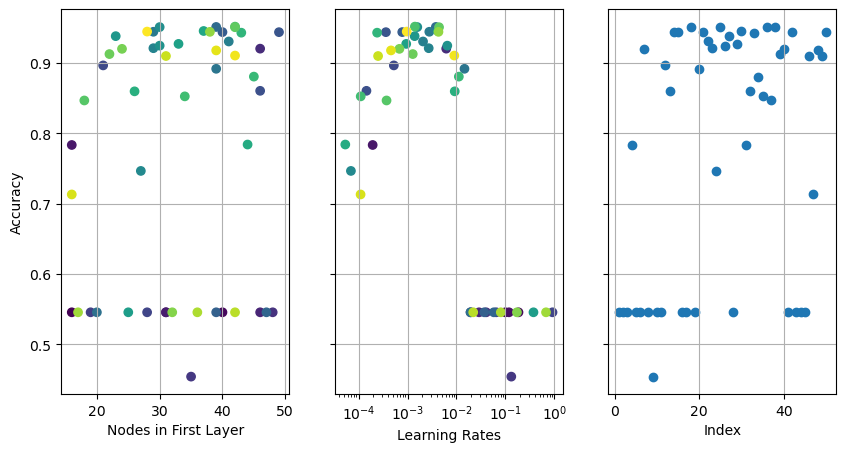

In [30]:
_ , (ax1 , ax2 , ax3) = plt.subplots(1 , 3 , sharey = True , figsize = (10 , 5))

nodes = np.array([t['misc']['vals']['init_nodes'][0] for t in trials.trials])
rates = np.array([t['misc']['vals']['leran_rate'][0] for t in trials.trials])
indxs = np.array([t['tid']+1 for t in trials.trials])
accs  = np.array([-t['result']['loss'] for t in trials.trials])

ax1.scatter(nodes , accs , c = indxs)
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Nodes in First Layer')
ax1.grid()

ax2.scatter(rates , accs , c = indxs)
ax2.set(
    xscale = 'log' ,
    xlabel = 'Learning Rates'
)
ax2.grid()

ax3.scatter(indxs , accs)
ax3.set_xlabel('Index')
ax3.grid()

plt.show()

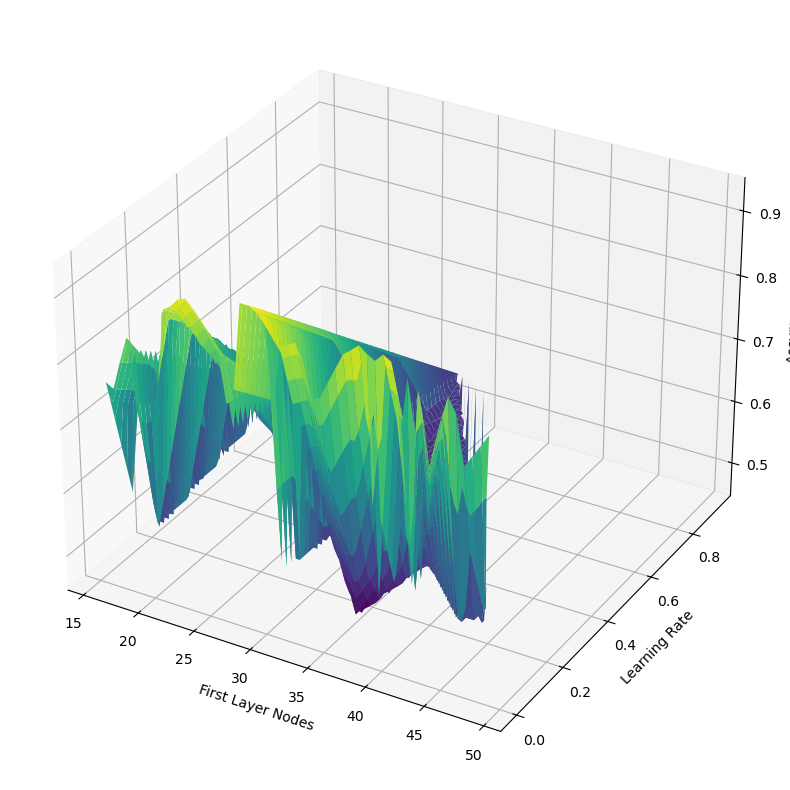

In [34]:
from scipy.interpolate import griddata

xi = np.linspace(min(nodes), max(nodes), 100)
yi = np.linspace(min(rates), max(rates), 100)
xi, yi = np.meshgrid(xi, yi)

zi = griddata((nodes, rates), accs, (xi, yi))

fig = plt.figure(figsize = (10 , 10))
ax = fig.add_subplot(111, projection='3d')



# ax.contourf(xi , yi , zi , zdir='z', offset = min(accs), cmap='viridis')
# ax.contourf(xi , yi , zi , zdir='x', offset = min(nodes), cmap='viridis')
# ax.contourf(xi , yi , zi , zdir='y', offset = max(rates), cmap='viridis')

ax.plot_surface(xi, yi, zi, cmap='viridis')


ax.set(xlabel='First Layer Nodes', ylabel='Learning Rate', zlabel='Accyracy')

plt.show()


/tmp/ipykernel_2136/1934133353.py:5: UserWarning: The following kwargs were not used by contour: 'zdir', 'offset'
  cset = ax.contourf(xi, yi, zi, zdir='x', offset=min(rates), cmap='viridis', alpha=0.5)


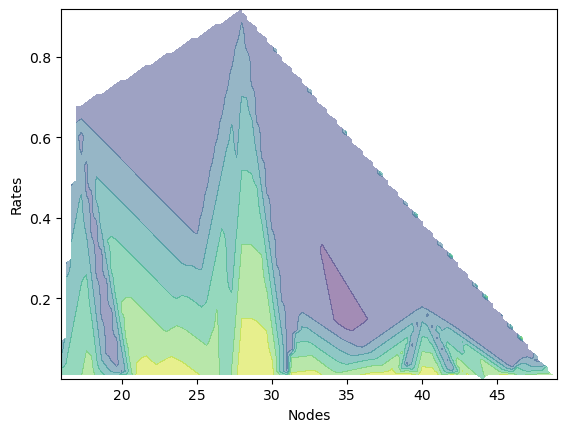

In [28]:
fig = plt.figure()
ax = fig.add_subplot()


cset = ax.contourf(xi, yi, zi, zdir='x', offset=min(rates), cmap='viridis', alpha=0.5)

ax.set_xlabel('Nodes')
ax.set_ylabel('Rates')

plt.show()

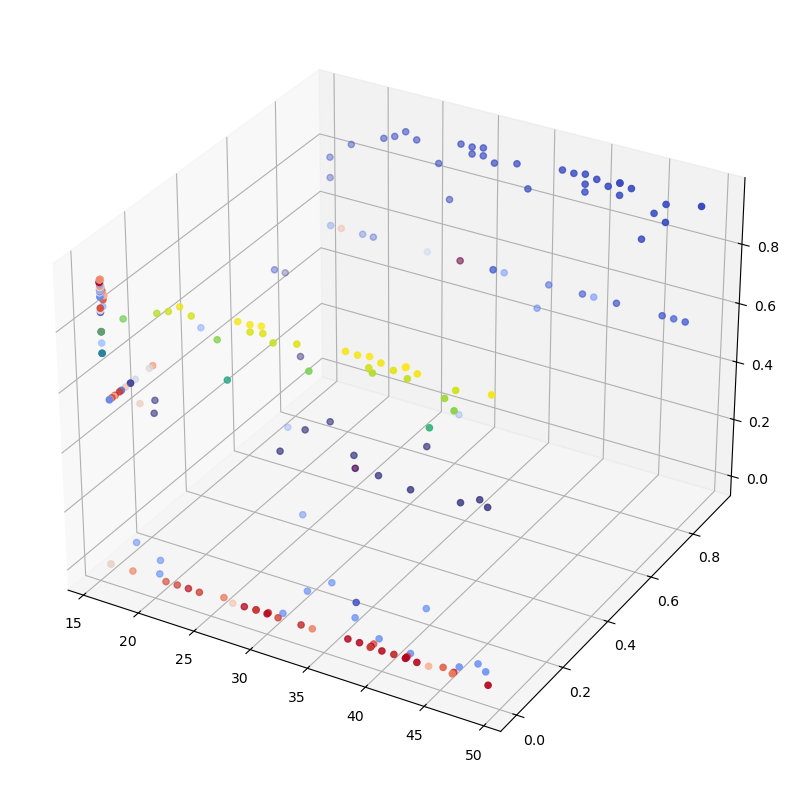

In [54]:
fig = plt.figure(figsize = (10 , 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(nodes , rates , accs , c = accs)

ax.scatter(nodes , rates , cmap='coolwarm' , c = accs)
ax.scatter(nodes , [max(rates) for n in nodes] , accs , cmap='coolwarm' , c = rates)
ax.scatter([min(nodes) for r in rates] , rates , accs , cmap='coolwarm' , c = nodes)


plt.show()